# VPoser

In [1]:
# Set up environment
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
# %matplotlib inline

from pathlib import Path
import numpy as np
import torch
from tinyhumans.models import SMPLX, VPoser
from tinyhumans.models.vposer import load_model

from tinyhumans.renderer import PyRenderer
from tinyhumans.tools import image_grid, plot_meshes

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
# This tutorial requires 'vposer_v2_05'
support_dir = Path("..", "downloads")
expr_dir = Path(
    support_dir, "models", "vposer_v2.05"
)  #'TRAINED_MODEL_DIRECTORY'  in this directory the trained model along with the model code exist
# bm_fname = "/Users/abenetatos/GitRepos/tinyhumans/SMPLX_NEUTRAL_2020.npz" # same as the other + FLAME face model values are non zero
bm_fname = Path(
    support_dir, "models", "smplx", "SMPLX_NEUTRAL.npz"
)  #'PATH_TO_SMPLX_model.npz'  obtain from https://smpl-x.is.tue.mpg.de/downloads
sample_amass_fname = Path(support_dir, "amass_sample.npz")  # a sample npz file from AMASS

In [3]:
# Loading SMPLx Body Model
smplx_model = SMPLX(pretrained_model_path=bm_fname).to(device)

In [4]:
# Loading VPoser Body Pose Prior
vp, ps = load_model(expr_dir, model_code=VPoser, remove_words_in_model_weights="vp_model.", disable_grad=True)
vp = vp.to(device)

/Users/abenetatos/GitRepos/tinyhumans/src/tinyhumans/models/vposer/vposer_model.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(trained_weights

## Encoding a body_pose (pose>poZ)
We will load an [AMASS](http://amass.is.tue.mpg.de/) sample and place the body pose on the right device for batch processing. To learn more on AMASS data loading refer to [link](https://github.com/nghorbani/amass/blob/master/notebooks/01-AMASS_Visualization.ipynb).

In [5]:
# Prepare the pose_body from amass sample
amass_body_pose = np.load(sample_amass_fname)["poses"][:, 3:66]
amass_body_pose = torch.from_numpy(amass_body_pose).type(torch.float).to(device)
print("amass_body_pose.shape", amass_body_pose.shape)

amass_body_pose.shape torch.Size([500, 63])


In [6]:
amass_body_pose.shape

torch.Size([500, 63])

In [7]:
amass_body_poZ = vp.encode(amass_body_pose).mean
print("amass_body_poZ.shape", amass_body_poZ.shape)

amass_body_poZ.shape torch.Size([500, 32])


## Decoding a body_poZ (poZ>pose)
We will decode the same poZ in order to reconstruct the pose and will visualize it for a random frame.

In [8]:
amass_body_pose_rec = vp.decode(amass_body_poZ)["pose_body"].contiguous().view(-1, 63)
print("amass_body_pose_rec.shape", amass_body_poZ.shape)

amass_body_pose_rec.shape torch.Size([500, 32])


In [9]:
##Let's visualize the original pose and the reconstructed one:
t = np.random.choice(len(amass_body_pose))

all_pose_body = torch.stack([amass_body_pose[t], amass_body_pose_rec[t]])

all_pose_body.shape

torch.Size([2, 63])

In [ ]:
betas = torch.randn([2, 10], dtype=torch.float32).to("mps")
smplx_meshes = smplx_model(poses={"body": all_pose_body}, shape_components={"betas": betas}).cpu()
fig = plot_meshes(smplx_meshes, join=True, show=True, subplot_size=800, subplot_titles=None)

In [11]:
renderer = PyRenderer(
    image_size=(600, 600),
    bg_color=(0.99, 0.99, 0.99),
    ambient_light=(0.5, 0.5, 0.5),
    use_raymond_lighting=True,
    use_direct_lighting=False,
    camera_params={"translation": [0.0, -0.4, 2.5], "rotation": np.eye(3), "yfov": np.pi / 3.0},
)

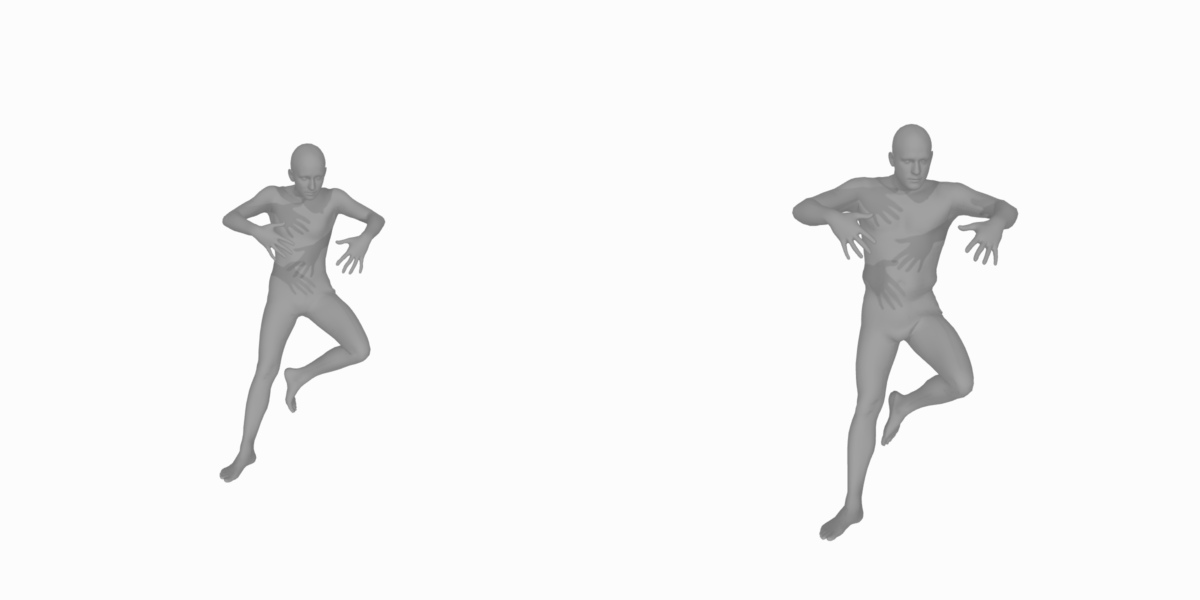

In [12]:
images = [
    renderer(
        mesh,
        render_params={
            "render_face_normals": False,
            "render_in_RGBA": False,
            "render_segmentation": False,
            "render_shadows": True,
            "render_vertex_normals": False,
            "render_wireframe": False,
            "skip_cull_faces": False,
        },
    )
    for mesh in smplx_meshes
]

image_grid([image[0] for image in images], rows=1, cols=len(images))

The closer above two bodies look similar to each other, the more successful is VPoser is in reconstructing the original data space body pose parameters.

## Generate novel body poses

poZ_body_sample.shape torch.Size([1, 32])
pose_body.shape torch.Size([1, 63])


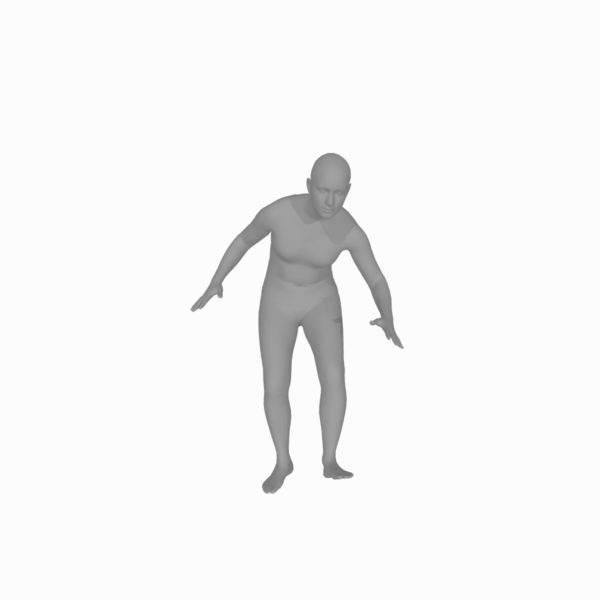

In [13]:
# Sample a 32 dimensional vector from a Normal distribution
poZ_body_sample = torch.from_numpy(np.random.randn(1, 32).astype(np.float32)).to(device)
pose_body = vp.decode(poZ_body_sample)["pose_body"].contiguous().view(-1, 63)

print("poZ_body_sample.shape", poZ_body_sample.shape)
print("pose_body.shape", pose_body.shape)

smplx_meshes = smplx_model(poses={"body": pose_body}).cpu()

images = [
    renderer(
        mesh,
        render_params={
            "render_face_normals": False,
            "render_in_RGBA": False,
            "render_segmentation": False,
            "render_shadows": True,
            "render_vertex_normals": False,
            "render_wireframe": False,
            "skip_cull_faces": False,
        },
    )
    for mesh in smplx_meshes
]

images[0][0]

Above we drawn a sample from a 32 dimensional Normal distribution and decoded its value to a full 63 dimensional SMPL body pose vector. The generated image shows the corresponding rendered body. Fo an advanced tutorial on generating poses with VPoser refer to [Link](notebooks/vposer_sampling.ipynb).